# LSTM/Transformer Stage-wise Pipeline (Baseline -> Residual -> RoR)

This notebook mirrors the **baseline -> residual -> RoR** flow with deep learning models.
Models: **LSTM**, **Transformer**.



In [23]:
# Optional: uncomment if packages are missing
# !pip install torch pandas scikit-learn matplotlib



In [24]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device



device(type='cpu')

In [25]:
# Config
DATA_PATH = 'data_weekly_260120.csv'
TARGET = 'Com_LME_Ni_Cash'
SEQ_LEN = 24
BATCH_SIZE = 32

EPOCHS_BASE = 5
EPOCHS_RESID = 5
EPOCHS_ROR = 5
LR = 1e-3

VAL_START = '2025-08-04'
VAL_END = '2025-10-20'
TEST_START = '2025-10-27'
TEST_END = '2026-01-12'

MODEL_POOL = ['LSTM', 'Transformer']
TOP_K_RESID = 2
TOP_K_ROR = 2

# ROR definition
# ror = baseline_pred - residual
# residual = actual - baseline_pred
# => ror = 2*baseline_pred - actual
ROR_TARGET_MODE = 'pred_minus_residual'



In [26]:
# Data loading + feature engineering (same leakage-free setup as sparta2)
df_raw = pd.read_csv(DATA_PATH, parse_dates=['dt'])
df_raw = df_raw.set_index('dt').sort_index()


def filter_cols(columns):
    target = 'Com_LME_Ni_Cash'
    metals = ['Gold', 'Silver', 'Iron', 'Steel', 'Copper', 'Aluminum', 'Zinc', 'Nickel', 'Lead', 'Tin', 'Uranium']
    filtered = [target]
    for col in columns:
        if any(x in col for x in ['Idx_', 'Bonds_', 'EX_']):
            filtered.append(col)
        elif 'Com_LME' in col:
            filtered.append(col)
        elif any(m in col for m in metals):
            filtered.append(col)
    return sorted(list(set(filtered)))


filtered_cols = filter_cols(df_raw.columns)
df = df_raw[filtered_cols].copy().ffill().dropna()

# Returns for features: log for positive-only series, diff for non-positive series
non_pos_cols = [c for c in df.columns if (df[c] <= 0).any()]
pos_cols = [c for c in df.columns if c not in non_pos_cols]

# Feature returns
df_ret = pd.DataFrame(index=df.index)
df_ret[pos_cols] = np.log(df[pos_cols] / df[pos_cols].shift(1))
df_ret[non_pos_cols] = df[non_pos_cols].diff()

# No leakage: lag features by 1 week
x_cols = [c for c in df_ret.columns if c != TARGET]
X = df_ret[x_cols].shift(1)
y = df[TARGET]

valid_idx = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_idx]
y = y.loc[valid_idx]

print('Feature count:', X.shape[1])
print('Total samples:', len(y))



Feature count: 51
Total samples: 666


In [27]:
# Split + scaling + sequence builder
train_mask = X.index < VAL_START
val_mask = (X.index >= VAL_START) & (X.index <= VAL_END)
test_mask = (X.index >= TEST_START) & (X.index <= TEST_END)

if train_mask.sum() == 0 or val_mask.sum() == 0 or test_mask.sum() == 0:
    raise ValueError('Split resulted in empty train/val/test. Check date ranges or data coverage.')

x_scaler = StandardScaler()
x_scaler.fit(X.loc[train_mask].values)
X_scaled = pd.DataFrame(x_scaler.transform(X.values), index=X.index, columns=X.columns)

# Scale target with train-only stats to stabilize NN training
# (prevents tiny Adam steps when y is large)
y_scaler = StandardScaler()
y_scaler.fit(y.loc[train_mask].values.reshape(-1, 1))
y_scaled = pd.Series(y_scaler.transform(y.values.reshape(-1, 1)).ravel(), index=y.index)


def make_sequences(X_df, y_series, seq_len):
    X_values = X_df.values.astype(np.float32)
    y_values = y_series.values.astype(np.float32)
    idx = y_series.index
    X_seq = []
    y_seq = []
    idx_seq = []
    for i in range(seq_len - 1, len(X_values)):
        X_seq.append(X_values[i - seq_len + 1:i + 1])
        y_seq.append(y_values[i])
        idx_seq.append(idx[i])
    return np.stack(X_seq), np.array(y_seq), pd.Index(idx_seq)


X_seq, y_seq_scaled, idx_seq = make_sequences(X_scaled, y_scaled, SEQ_LEN)
# Raw price targets aligned to the same indices (for metrics/plots)
y_seq_raw = y.loc[idx_seq].values.astype(np.float32)

train_seq_mask = idx_seq < VAL_START
val_seq_mask = (idx_seq >= VAL_START) & (idx_seq <= VAL_END)
test_seq_mask = (idx_seq >= TEST_START) & (idx_seq <= TEST_END)

X_train_seq, y_train_seq = X_seq[train_seq_mask], y_seq_scaled[train_seq_mask]
X_val_seq, y_val_seq = X_seq[val_seq_mask], y_seq_scaled[val_seq_mask]
X_test_seq, y_test_seq = X_seq[test_seq_mask], y_seq_scaled[test_seq_mask]

idx_train_seq = idx_seq[train_seq_mask]
idx_val_seq = idx_seq[val_seq_mask]
idx_test_seq = idx_seq[test_seq_mask]

y_train_seq_raw = y_seq_raw[train_seq_mask]
y_val_seq_raw = y_seq_raw[val_seq_mask]
y_test_seq_raw = y_seq_raw[test_seq_mask]

print('Train seq:', X_train_seq.shape, 'Val seq:', X_val_seq.shape, 'Test seq:', X_test_seq.shape)


Train seq: (619, 24, 51) Val seq: (12, 24, 51) Test seq: (12, 24, 51)


In [28]:
# Dataset / DataLoader helpers
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def make_loader(X, y, batch_size=BATCH_SIZE, shuffle=False):
    ds = SeqDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)


train_loader = make_loader(X_train_seq, y_train_seq, shuffle=True)
train_eval_loader = make_loader(X_train_seq, y_train_seq, shuffle=False)
val_loader = make_loader(X_val_seq, y_val_seq, shuffle=False)
test_loader = make_loader(X_test_seq, y_test_seq, shuffle=False)



In [29]:
# Models + training utils
class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1]
        return self.fc(last).squeeze(-1)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


class TransformerForecaster(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.encoder(x)
        last = x[:, -1]
        return self.fc(last).squeeze(-1)


def build_model(name, n_features):
    if name == 'LSTM':
        return LSTMForecaster(n_features=n_features)
    if name == 'Transformer':
        return TransformerForecaster(n_features=n_features)
    raise ValueError(f'Unknown model: {name}')


def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    preds = []
    trues = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        total_loss += loss.item() * x.size(0)
        preds.append(pred.cpu().numpy())
        trues.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    return total_loss / len(loader.dataset), preds, trues


def fit_model(model, train_loader, val_loader=None, epochs=5, lr=LR):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    if val_loader is None:
        for _ in range(epochs):
            train_one_epoch(model, train_loader, optimizer, loss_fn)
        return model

    best_val = np.inf
    best_state = None

    for _ in range(epochs):
        train_one_epoch(model, train_loader, optimizer, loss_fn)
        val_loss, _, _ = evaluate(model, val_loader, loss_fn)
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    eps = 1e-8
    denom = np.where(np.abs(y_true) < eps, np.nan, np.abs(y_true))
    ape = np.abs((y_true - y_pred) / denom)
    spe = ((y_true - y_pred) / denom) ** 2
    mape = np.nanmean(ape) * 100
    rmspe = np.sqrt(np.nanmean(spe)) * 100
    return rmse, rmspe, mape, mae


def to_price(y_scaled):
    y_scaled = np.asarray(y_scaled).reshape(-1, 1)
    return y_scaler.inverse_transform(y_scaled).ravel()


def append_meta(X_seq, base_pred, resid_pred):
    base = base_pred.reshape(-1, 1, 1).astype(np.float32)
    resid = resid_pred.reshape(-1, 1, 1).astype(np.float32)
    base_rep = np.repeat(base, X_seq.shape[1], axis=1)
    resid_rep = np.repeat(resid, X_seq.shape[1], axis=1)
    return np.concatenate([X_seq, base_rep, resid_rep], axis=2)


def ror_target(y_true, base_pred):
    # ror = baseline_pred - residual = 2*baseline_pred - actual
    return (2 * base_pred) - y_true


def ror_pred_to_price(ror_pred, base_pred):
    return (2 * base_pred) - ror_pred


In [30]:
# 1) Baseline selection on validation
baseline_results = []
base_pred_train = {}
base_pred_val = {}

for name in MODEL_POOL:
    model = build_model(name, n_features=X_train_seq.shape[2])
    model = fit_model(model, train_loader, val_loader, epochs=EPOCHS_BASE)

    _, pred_train, _ = evaluate(model, train_eval_loader, nn.MSELoss())
    _, pred_val, _ = evaluate(model, val_loader, nn.MSELoss())

    # keep scaled preds for residual/ROR
    base_pred_train[name] = pred_train
    base_pred_val[name] = pred_val

    pred_val_price = to_price(pred_val)
    rmse, rmspe, mape, mae = eval_metrics(y_val_seq_raw, pred_val_price)
    baseline_results.append({'Model': name, 'VAL_RMSE': rmse, 'VAL_RMSPE': rmspe, 'VAL_MAPE': mape, 'VAL_MAE': mae})

baseline_df = pd.DataFrame(baseline_results).sort_values('VAL_RMSE')
print('Baseline validation results:')
display(baseline_df)

baseline_top2 = baseline_df['Model'].head(2).tolist()
print('Baseline top-2:', baseline_top2)


Baseline validation results:


,Model,VAL_RMSE,VAL_RMSPE,VAL_MAPE,VAL_MAE
0,LSTM,461.615523,3.056327,2.630758,396.781158
1,Transformer,1020.958496,6.790214,6.382596,959.710144


Baseline top-2: ['LSTM', 'Transformer']


In [31]:
# 2) Residual + ROR combo search (validation)
resid_rows = []

for base_name in baseline_top2:
    resid_target_train = y_train_seq - base_pred_train[base_name]
    resid_train_loader = make_loader(X_train_seq, resid_target_train, shuffle=True)

    resid_target_val = y_val_seq - base_pred_val[base_name]
    resid_val_loader = make_loader(X_val_seq, resid_target_val, shuffle=False)

    for resid_name in MODEL_POOL:
        resid_model = build_model(resid_name, n_features=X_train_seq.shape[2])
        resid_model = fit_model(resid_model, resid_train_loader, resid_val_loader, epochs=EPOCHS_RESID)

        _, resid_pred_val, _ = evaluate(resid_model, resid_val_loader, nn.MSELoss())
        y_pred_val_scaled = base_pred_val[base_name] + resid_pred_val
        y_pred_val = to_price(y_pred_val_scaled)

        rmse, rmspe, mape, mae = eval_metrics(y_val_seq_raw, y_pred_val)
        resid_rows.append({
            'Base': base_name,
            'Residual': resid_name,
            'VAL_RMSE': rmse,
            'VAL_RMSPE': rmspe,
            'VAL_MAPE': mape,
            'VAL_MAE': mae
        })

resid_df = pd.DataFrame(resid_rows).sort_values('VAL_RMSE')
print('Top Residual combos (val):')
display(resid_df.head(TOP_K_RESID))

resid_top = resid_df.head(TOP_K_RESID)

# ROR combos (expand from top residual combos)
ror_rows = []
for _, row in resid_top.iterrows():
    base_name = row['Base']
    resid_name = row['Residual']

    # retrain residual model to get train/val preds
    resid_target_train = y_train_seq - base_pred_train[base_name]
    resid_train_loader = make_loader(X_train_seq, resid_target_train, shuffle=True)
    resid_target_val = y_val_seq - base_pred_val[base_name]
    resid_val_loader = make_loader(X_val_seq, resid_target_val, shuffle=False)

    resid_model = build_model(resid_name, n_features=X_train_seq.shape[2])
    resid_model = fit_model(resid_model, resid_train_loader, resid_val_loader, epochs=EPOCHS_RESID)

    _, resid_pred_train, _ = evaluate(resid_model, train_eval_loader, nn.MSELoss())
    _, resid_pred_val, _ = evaluate(resid_model, resid_val_loader, nn.MSELoss())

    X_train_meta = append_meta(X_train_seq, base_pred_train[base_name], resid_pred_train)
    X_val_meta = append_meta(X_val_seq, base_pred_val[base_name], resid_pred_val)

    ror_y_train = ror_target(y_train_seq, base_pred_train[base_name])
    ror_y_val = ror_target(y_val_seq, base_pred_val[base_name])

    ror_train_loader = make_loader(X_train_meta, ror_y_train, shuffle=True)
    ror_val_loader = make_loader(X_val_meta, ror_y_val, shuffle=False)

    for ror_name in MODEL_POOL:
        ror_model = build_model(ror_name, n_features=X_train_meta.shape[2])
        ror_model = fit_model(ror_model, ror_train_loader, ror_val_loader, epochs=EPOCHS_ROR)

        _, ror_pred_val, _ = evaluate(ror_model, ror_val_loader, nn.MSELoss())
        y_pred_val_scaled = ror_pred_to_price(ror_pred_val, base_pred_val[base_name])
        y_pred_val = to_price(y_pred_val_scaled)

        rmse, rmspe, mape, mae = eval_metrics(y_val_seq_raw, y_pred_val)
        ror_rows.append({
            'Base': base_name,
            'Residual': resid_name,
            'ROR': ror_name,
            'VAL_RMSE': rmse,
            'VAL_RMSPE': rmspe,
            'VAL_MAPE': mape,
            'VAL_MAE': mae
        })

ror_df = pd.DataFrame(ror_rows).sort_values('VAL_RMSE')
print('Top ROR combos (val):')
display(ror_df.head(TOP_K_ROR))


Top Residual combos (val):


,Base,Residual,VAL_RMSE,VAL_RMSPE,VAL_MAPE,VAL_MAE
3,Transformer,Transformer,685.198671,4.554137,3.785756,569.594238
2,Transformer,LSTM,686.727498,4.563706,4.158085,625.536682


Top ROR combos (val):


,Base,Residual,ROR,VAL_RMSE,VAL_RMSPE,VAL_MAPE,VAL_MAE
2,Transformer,LSTM,LSTM,721.754027,4.798087,3.950266,593.956543
0,Transformer,Transformer,LSTM,818.593802,5.442763,4.926053,740.822693


In [32]:
# 3) Final training (train+val) -> test evaluation
# Build train+val loaders
X_train_full = np.concatenate([X_train_seq, X_val_seq], axis=0)
y_train_full = np.concatenate([y_train_seq, y_val_seq], axis=0)

train_full_loader = make_loader(X_train_full, y_train_full, shuffle=True)
train_full_eval_loader = make_loader(X_train_full, y_train_full, shuffle=False)

results = []
preds = pd.DataFrame(index=idx_test_seq)
preds['Actual'] = y_test_seq_raw

# Baseline test
base_pred_train_full = {}
base_pred_test = {}

for name in MODEL_POOL:
    model = build_model(name, n_features=X_train_full.shape[2])
    model = fit_model(model, train_full_loader, val_loader=None, epochs=EPOCHS_BASE)

    _, pred_train_full, _ = evaluate(model, train_full_eval_loader, nn.MSELoss())
    _, pred_test, _ = evaluate(model, test_loader, nn.MSELoss())

    # keep scaled preds for residual/ROR
    base_pred_train_full[name] = pred_train_full
    base_pred_test[name] = pred_test

    pred_test_price = to_price(pred_test)
    preds[f'BASE_{name}'] = pred_test_price
    rmse, rmspe, mape, mae = eval_metrics(y_test_seq_raw, pred_test_price)
    results.append({'Model': f'BASE_{name}', 'RMSE': rmse, 'RMSPE': rmspe, 'MAPE': mape, 'MAE': mae})

# Residual test (use top residual combos)
resid_top = resid_df.head(TOP_K_RESID)

for _, row in resid_top.iterrows():
    base_name = row['Base']
    resid_name = row['Residual']

    resid_target_train_full = y_train_full - base_pred_train_full[base_name]
    resid_train_loader = make_loader(X_train_full, resid_target_train_full, shuffle=True)

    resid_model = build_model(resid_name, n_features=X_train_full.shape[2])
    resid_model = fit_model(resid_model, resid_train_loader, val_loader=None, epochs=EPOCHS_RESID)
    _, resid_pred_test, _ = evaluate(resid_model, test_loader, nn.MSELoss())

    pred_test_scaled = base_pred_test[base_name] + resid_pred_test
    pred_test_price = to_price(pred_test_scaled)
    model_key = f'RES_{base_name}+{resid_name}'
    preds[model_key] = pred_test_price

    rmse, rmspe, mape, mae = eval_metrics(y_test_seq_raw, pred_test_price)
    results.append({'Model': model_key, 'RMSE': rmse, 'RMSPE': rmspe, 'MAPE': mape, 'MAE': mae})

# ROR test (use top ROR combos)
ror_top = ror_df.head(TOP_K_ROR)
for _, row in ror_top.iterrows():
    base_name = row['Base']
    resid_name = row['Residual']
    ror_name = row['ROR']

    resid_target_train_full = y_train_full - base_pred_train_full[base_name]
    resid_train_loader = make_loader(X_train_full, resid_target_train_full, shuffle=True)

    resid_model = build_model(resid_name, n_features=X_train_full.shape[2])
    resid_model = fit_model(resid_model, resid_train_loader, val_loader=None, epochs=EPOCHS_RESID)

    _, resid_pred_train_full, _ = evaluate(resid_model, train_full_eval_loader, nn.MSELoss())
    _, resid_pred_test, _ = evaluate(resid_model, test_loader, nn.MSELoss())

    X_train_meta = append_meta(X_train_full, base_pred_train_full[base_name], resid_pred_train_full)
    X_test_meta = append_meta(X_test_seq, base_pred_test[base_name], resid_pred_test)

    ror_y_train_full = ror_target(y_train_full, base_pred_train_full[base_name])

    ror_train_loader = make_loader(X_train_meta, ror_y_train_full, shuffle=True)
    ror_test_loader = make_loader(X_test_meta, y_test_seq, shuffle=False)

    ror_model = build_model(ror_name, n_features=X_train_meta.shape[2])
    ror_model = fit_model(ror_model, ror_train_loader, val_loader=None, epochs=EPOCHS_ROR)

    _, ror_pred_test, _ = evaluate(ror_model, ror_test_loader, nn.MSELoss())
    pred_test_scaled = ror_pred_to_price(ror_pred_test, base_pred_test[base_name])
    pred_test_price = to_price(pred_test_scaled)

    model_key = f'ROR_{base_name}+{resid_name}+{ror_name}'
    preds[model_key] = pred_test_price

    rmse, rmspe, mape, mae = eval_metrics(y_test_seq_raw, pred_test_price)
    results.append({'Model': model_key, 'RMSE': rmse, 'RMSPE': rmspe, 'MAPE': mape, 'MAE': mae})

results_df = pd.DataFrame(results).set_index('Model').sort_values('RMSE')
print('Test results:')
display(results_df)


Test results:


,RMSE,RMSPE,MAPE,MAE
Model,,,,
ROR_Transformer+Transformer+LSTM,684.337545,4.574068,3.967982,599.829041
RES_Transformer+Transformer,723.654096,4.458372,3.804533,599.370422
BASE_Transformer,955.191309,5.891285,5.040321,790.828430
ROR_Transformer+LSTM+LSTM,975.920719,5.976830,4.614016,732.356262
RES_Transformer+LSTM,1284.703030,8.157820,6.627940,1035.045044
BASE_LSTM,1957.663659,13.365567,11.609288,1712.086792


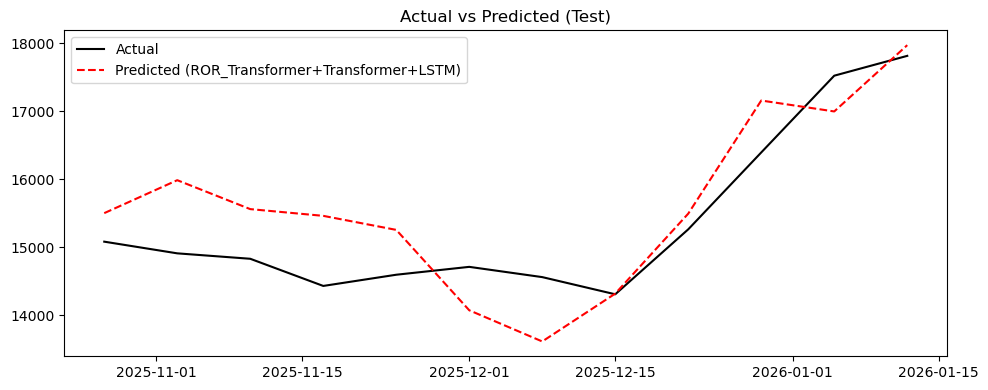

In [33]:
# Plot best model vs actual
best_model = results_df.index[0]
plt.figure(figsize=(10, 4))
plt.plot(preds.index, preds['Actual'], label='Actual', color='black')
plt.plot(preds.index, preds[best_model], label=f'Predicted ({best_model})', color='red', linestyle='--')
plt.title('Actual vs Predicted (Test)')
plt.legend()
plt.tight_layout()
plt.show()



## Next steps
- Increase epochs for stability (baseline/residual/ROR).
- Try larger SEQ_LEN or add more DL architectures.
- Compare with tree-based pipeline in sparta2.ipynb.

